## Dependencies and imports

In [1]:
import sys

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 777

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

input_size = 1024
train_size = 1024
traincrop = False
mixup = True
source = None
balance = False

effmodel = "effdet5"

misc = str(train_size)+"-2"
if traincrop:
    misc += "_traincrop"
if mixup:
    misc += "_mixup"
if balance:
    misc += "_balance"
if source !=None:
    misc += "source{}".format(source)
    
modelpath = '{}-cutmix-{}/last-checkpoint.bin'.format(effmodel,misc)

import re

In [2]:
DIR_INPUT = 'data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [3]:
# get a df with just image and source columns
# such that dropping duplicates will only keep unique image_ids
from sklearn.model_selection import StratifiedKFold
from itertools import islice

df = pd.read_csv(f'{DIR_INPUT}/train.csv')
image_source = df[['image_id', 'source']].drop_duplicates()

# get lists for image_ids and sources
image_ids = image_source['image_id'].to_numpy()
sources = image_source['source'].to_numpy()

# do the split
# in other words:
# split up our data into 10 buckets making sure that each bucket
#  has a more or less even distribution of sources
# Note the use of random_state=1 to ensure the split is the same each time we run this code
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
split = skf.split(image_ids, sources) # second arguement is what we are stratifying by

# we can use islice to control which split we select
select = 0
train_ix, val_ix = next(islice(split, select, select+1))

# translate indices to ids
train_id = image_ids[train_ix]
val_id = image_ids[val_ix]

# create corresponding dfs
val_df = train_df[train_df['image_id'].isin(val_id)]
train_df = train_df[train_df['image_id'].isin(train_id)]

print(len(train_id))
print(len(val_id))

2696
677


## Albumentations

In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.ShiftScaleRotate(p=0.75, rotate_limit=30, shift_limit=0.1,
          scale_limit=0.3, border_mode=cv2.BORDER_CONSTANT),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=train_size, width=train_size, p=1),
            A.Cutout(num_holes=12, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=input_size, width=input_size, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [5]:
TRAIN_ROOT_PATH = DIR_TRAIN

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.tensor(sample["bboxes"])
                    #target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [6]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=train_id,
    marking=train_df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=val_id,
    marking=val_df,
    transforms=get_valid_transforms(),
    test=True,
)

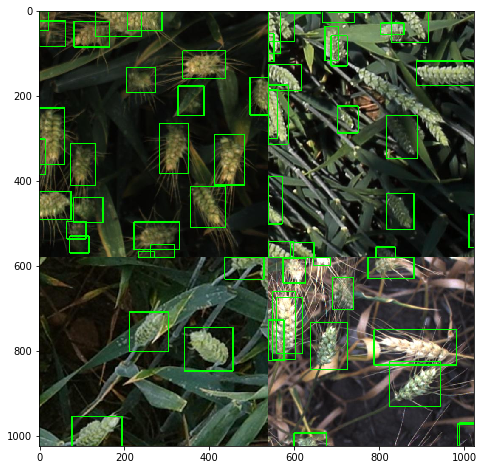

In [7]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax.imshow(numpy_image);

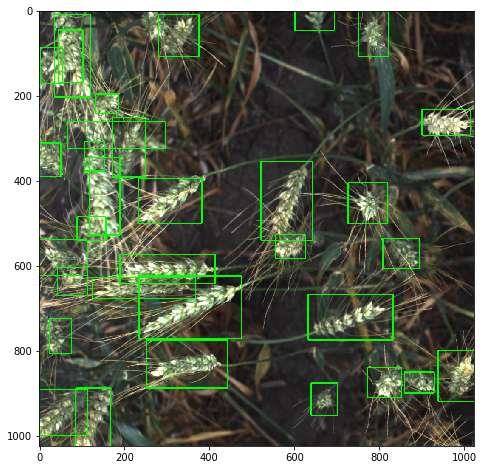

In [8]:
image, target, image_id = validation_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax.imshow(numpy_image);

## Fitter

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [11]:
class TrainGlobalConfig:
    num_workers = 8
    batch_size = 1
    n_epochs = 50
    lr = 0.0002

    folder = 'effdet5-cutmix-{}'.format(train_size)
    
    if traincrop:
        folder += "_traincrop"
    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.3,
        patience=3,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=True,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [13]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('weights/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = input_size
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

#net = get_net()

In [14]:
import gc
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
def load_net(checkpoint_path):
    if effmodel=="effdet5":
        config = get_efficientdet_config('tf_efficientdet_d5')
    elif effmodel=="effdet3":
        config = get_efficientdet_config('tf_efficientdet_d3')
    elif effmodel=="effdet7":
        config = get_efficientdet_config('tf_efficientdet_d7')
    elif effmodel=="effdet6":
        config = get_efficientdet_config('tf_efficientdet_d6')
    config.num_classes = 1
    config.image_size = input_size
    net = EfficientDet(config, pretrained_backbone=False)
    
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    print("loaded weights from ", checkpoint_path)
    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_net(modelpath)

loaded weights from  effdet5-cutmix-1024-2_mixup/last-checkpoint.bin


In [15]:
def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

from ensemble_boxes import *
def run_wbf(predictions, image_index, image_size=input_size, iou_thr=0.45, skip_box_thr=0.45, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [16]:
val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

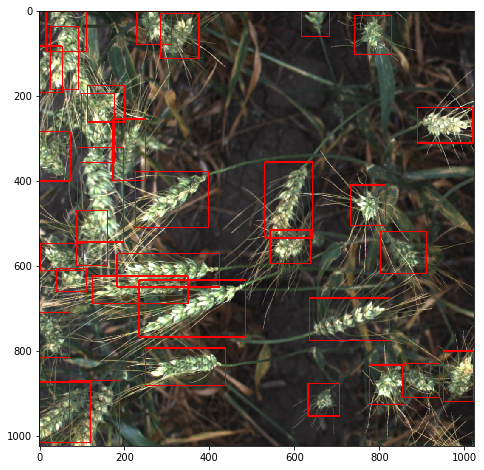

In [17]:
import matplotlib.pyplot as plt

for j, (images, target, image_ids) in enumerate(val_loader):
    break

predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=input_size)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    
ax.imshow(sample);

Precision at threshold 0.5: 0.6500
@0.50 = 0.6500
@0.55 = 0.5000
@0.60 = 0.4348
@0.65 = 0.3469
@0.70 = 0.2941
@0.75 = 0.2000

The average precision of the sample image: 0.4043
Precision at threshold 0.5: 0.7586
@0.50 = 0.7586
@0.55 = 0.7586
@0.60 = 0.7000
@0.65 = 0.7000
@0.70 = 0.6452
@0.75 = 0.5455

The average precision of the sample image: 0.6846
Precision at threshold 0.5: 0.8158
@0.50 = 0.8158
@0.55 = 0.7692
@0.60 = 0.7250
@0.65 = 0.6829
@0.70 = 0.6047
@0.75 = 0.5000

The average precision of the sample image: 0.6829
Precision at threshold 0.5: 0.7600
@0.50 = 0.7600
@0.55 = 0.7600
@0.60 = 0.6923
@0.65 = 0.6296
@0.70 = 0.4667
@0.75 = 0.4194

The average precision of the sample image: 0.6213
Precision at threshold 0.5: 0.6667
@0.50 = 0.6667
@0.55 = 0.6000
@0.60 = 0.4815
@0.65 = 0.3333
@0.70 = 0.2903
@0.75 = 0.2903

The average precision of the sample image: 0.4437
Precision at threshold 0.5: 0.8529
@0.50 = 0.8529
@0.55 = 0.8529
@0.60 = 0.8000
@0.65 = 0.8000
@0.70 = 0.7500
@0.75 = 0.

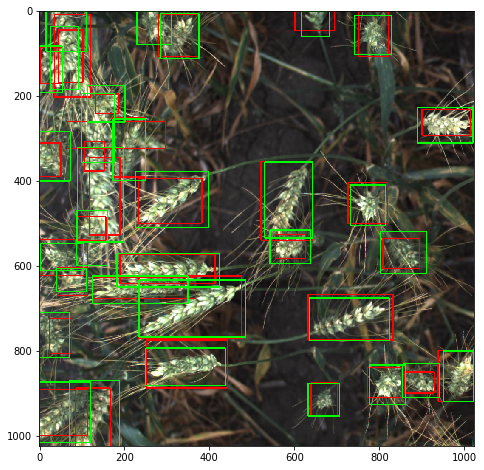

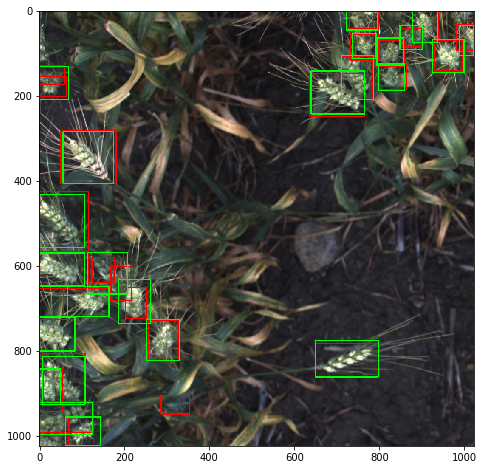

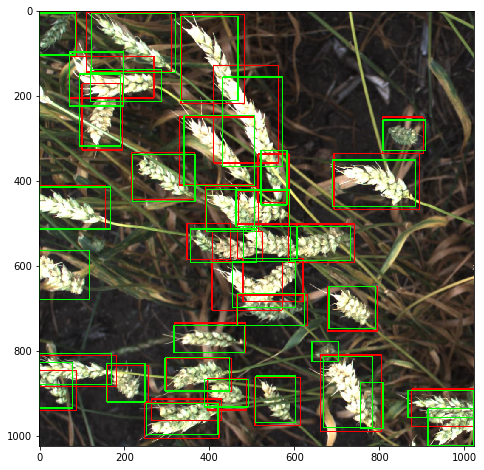

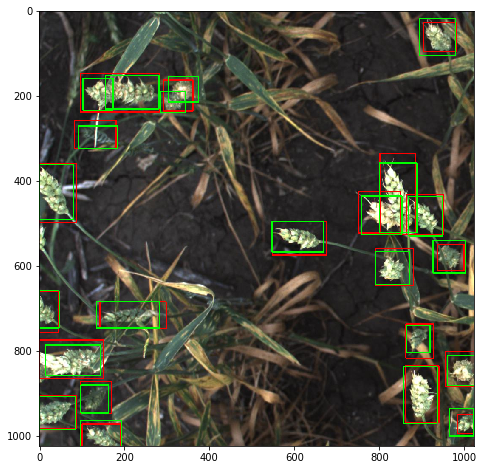

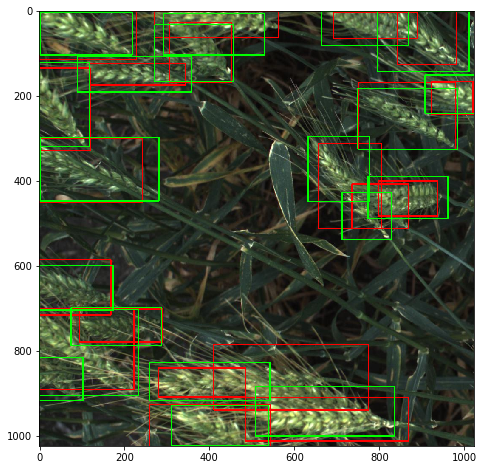

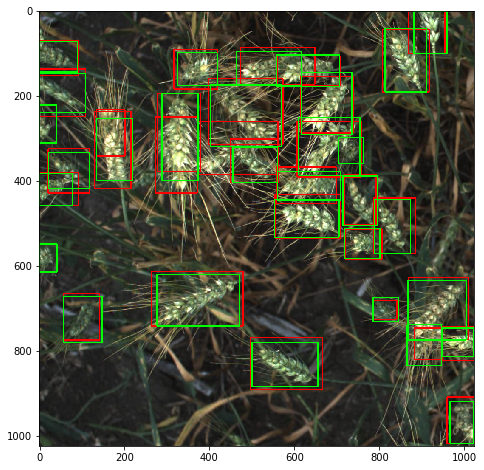

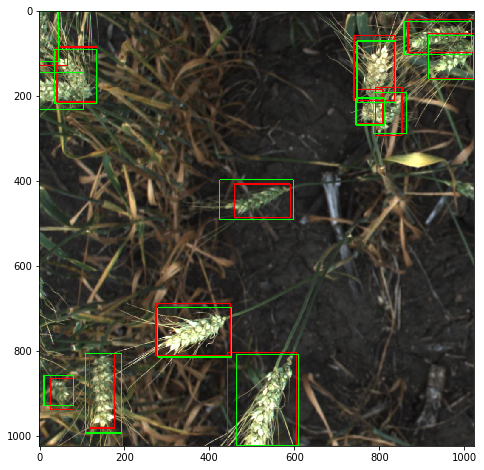

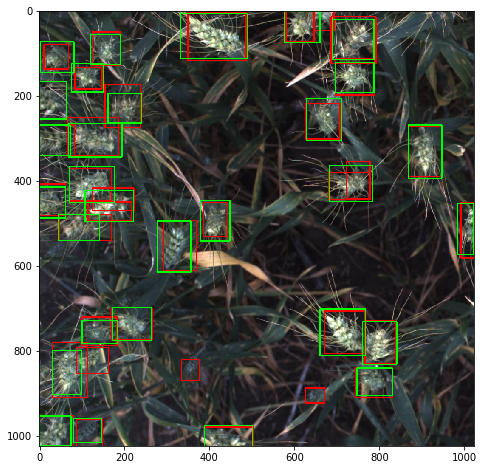

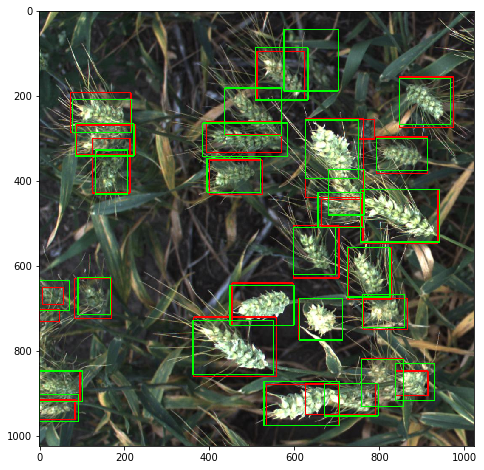

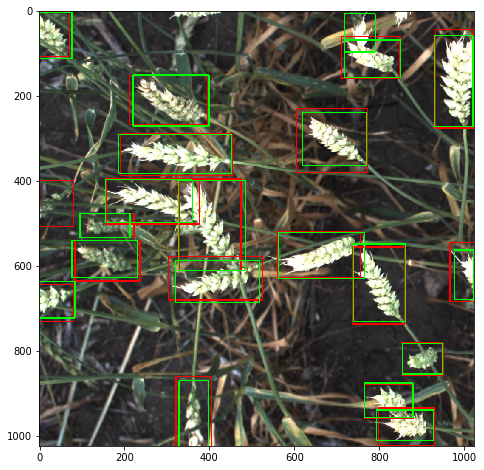

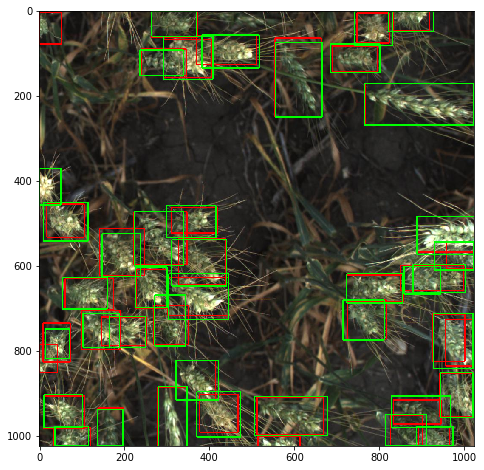

In [18]:
from metric import calculate_precision, calculate_image_precision
from utils import pascal2coco
torch.cuda.empty_cache()
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

for j, (images, target, image_ids) in enumerate(val_loader):
    i = 0
    boxes_gt = target[i]["boxes"].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()

    # predict
    predictions = make_predictions(images)

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=input_size)

    ###############################
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes_gt:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 1, 0), 2)
    ax.imshow(sample);

    # 2coco
    boxes = pascal2coco(boxes).astype("float")
    boxes_gt2 = pascal2coco(boxes_gt).astype("float")

    preds_sorted_idx = np.argsort(scores)[::-1]
    boxes_sorted = boxes[preds_sorted_idx]

    precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt2, threshold=0.5, form='coco')
    print("Precision at threshold 0.5: {0:.4f}".format(precision))

    image_precision = calculate_image_precision(boxes_sorted, boxes_gt2,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=True)

    print("\nThe average precision of the sample image: {0:.4f}".format(image_precision))
    
    if j == 10:
        break

In [20]:
from metric import calculate_precision, calculate_image_precision
from utils import pascal2coco
from tqdm import tqdm_notebook as tqdm

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]


import pandas as pd
log = []
# get x sources
image_source = val_df[['source']].drop_duplicates().to_numpy()[0:1]
thresh = 0.45

for thresh in np.arange(0.3, 0.6, 0.05):    
    idx = 0
    precision05 = 0
    precisions = 0
    # make df per source
    for source in image_source:
        
        print("evaluating for:", source)
        source_df = val_df[val_df['source'].isin(source)]
        source_id = source_df['image_id'].drop_duplicates().to_numpy()

        validation_dataset = DatasetRetriever(
            image_ids=source_id,
            marking=source_df,
            transforms=get_valid_transforms(),
            test=True,
        )

        val_loader = torch.utils.data.DataLoader(
                validation_dataset, 
                batch_size=TrainGlobalConfig.batch_size,
                num_workers=TrainGlobalConfig.num_workers,
                shuffle=False,
                sampler=SequentialSampler(validation_dataset),
                pin_memory=False,
                collate_fn=collate_fn,
            )

        # load data
        for j, (images, target, image_ids) in tqdm(enumerate(val_loader)):  
            # predict
            predictions = make_predictions(images)
            ps = []
            p05 = []
            for i in range(len(images)):
                boxes_gt = target[i]["boxes"].numpy()

                boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=thresh)
                boxes = boxes.astype(np.int32).clip(min=0, max=input_size)

                # 2coco
                boxes = pascal2coco(boxes).astype("float")
                boxes_gt = pascal2coco(boxes_gt)

                preds_sorted_idx = np.argsort(scores)[::-1]
                boxes_sorted = boxes[preds_sorted_idx]

                precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
                p05.append(precision)

                image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                    thresholds=iou_thresholds,
                                                    form='coco', debug=False)
                ps.append(image_precision)

            precision05 += np.mean(p05)
            precisions += np.mean(ps)
            idx += 1

        print("mAP at threshold 0.5: {}".format(precision05/idx))
        print("mAP at threshold 0.5:0.75: {}".format(precisions/idx))

        map50 = precision05/idx
        map5075 = precisions/idx

        # evaluate mAP based on each source
        result = {"source": source, "watermark": "effdet", "map50": map50, "map5075": map5075, "num_images": len(source_id),
                 "thresh": thresh}
        log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_effdet_{}.csv".format(misc))
df

evaluating for: ['usask_1']



mAP at threshold 0.5: 0.8304399973199672
mAP at threshold 0.5:0.75: 0.6927863495701382
evaluating for: ['usask_1']



mAP at threshold 0.5: 0.8348133741655236
mAP at threshold 0.5:0.75: 0.7031609382654742
evaluating for: ['usask_1']



mAP at threshold 0.5: 0.838582678248016
mAP at threshold 0.5:0.75: 0.7064019758190515
evaluating for: ['usask_1']



mAP at threshold 0.5: 0.8408881372536733
mAP at threshold 0.5:0.75: 0.7106369754982816
evaluating for: ['usask_1']



mAP at threshold 0.5: 0.8355321423236971
mAP at threshold 0.5:0.75: 0.7103195735710262
evaluating for: ['usask_1']



mAP at threshold 0.5: 0.8135195146270275
mAP at threshold 0.5:0.75: 0.6992495276010976


map50   map5075  num_images     source  thresh watermark
0  0.830440  0.692786          40  [usask_1]    0.30    effdet
1  0.834813  0.703161          40  [usask_1]    0.35    effdet
2  0.838583  0.706402          40  [usask_1]    0.40    effdet
3  0.840888  0.710637          40  [usask_1]    0.45    effdet
4  0.835532  0.710320          40  [usask_1]    0.50    effdet
5  0.813520  0.699250          40  [usask_1]    0.55    effdet

In [ ]:
from metric import calculate_precision, calculate_image_precision
from utils import pascal2coco
from tqdm import tqdm_notebook as tqdm

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]


import pandas as pd

log = []

# get x sources
image_source = val_df[['source']].drop_duplicates().to_numpy()

# make df per source
for source in image_source:
    idx = 0
    precision05 = 0
    precisions = 0
    print("evaluating for:", source)
    source_df = val_df[val_df['source'].isin(source)]
    source_id = source_df['image_id'].drop_duplicates().to_numpy()

    validation_dataset = DatasetRetriever(
        image_ids=source_id,
        marking=source_df,
        transforms=get_valid_transforms(),
        test=True,
    )

    val_loader = torch.utils.data.DataLoader(
            validation_dataset, 
            batch_size=TrainGlobalConfig.batch_size,
            num_workers=TrainGlobalConfig.num_workers,
            shuffle=False,
            sampler=SequentialSampler(validation_dataset),
            pin_memory=False,
            collate_fn=collate_fn,
        )

    # load data
    for j, (images, target, image_ids) in tqdm(enumerate(val_loader)):  
        # predict
        predictions = make_predictions(images)
        ps = []
        p05 = []
        for i in range(len(images)):
            boxes_gt = target[i]["boxes"].numpy()

            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=input_size)

            # 2coco
            boxes = pascal2coco(boxes).astype("float")
            boxes_gt = pascal2coco(boxes_gt)

            preds_sorted_idx = np.argsort(scores)[::-1]
            boxes_sorted = boxes[preds_sorted_idx]

            precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
            p05.append(precision)

            image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
            ps.append(image_precision)

        precision05 += np.mean(p05)
        precisions += np.mean(ps)
        idx += 1

    print("mAP at threshold 0.5: {}".format(precision05/idx))
    print("mAP at threshold 0.5:0.75: {}".format(precisions/idx))
    
    map50 = precision05/idx
    map5075 = precisions/idx
    
    # evaluate mAP based on each source
    result = {"source": source, "watermark": "effdet", "map50": map50, "map5075": map5075, "num_images": len(source_id)}
    log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_effdet_{}.csv".format(misc))

In [ ]:
df

# TTA

In [24]:
from tta import *

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(train_size), None], 
                               [TTAVerticalFlip(train_size), None],
                               [TTARotate90(train_size), None],
                               #[TTARotate90(train_size), None],
                               [TTAMultiply09(train_size), None],
                               [TTAMultiply11(train_size), None],
                               #[TTAResize(768, train_size), None],
                               ):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))



for tta_combination in product([TTAResize(896, train_size)],
                                [TTAHorizontalFlip(896), None], 
                               [TTAVerticalFlip(896), None],
                               [TTARotate90(896), None],
                               #[TTAMultiply09(train_size), None],
                               #[TTAMultiply11(train_size), None],
                               #[TTAResize(768, train_size), None],
                               ):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [25]:
def make_tta_predictions(images, score_threshold=0.3):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
        # No TTA
        det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            result.append({
                'boxes': boxes,
                'scores': scores[indexes],
            })
        predictions.append(result)
    return predictions

In [26]:
from metric import calculate_precision, calculate_image_precision
from utils import pascal2coco
from tqdm import tqdm_notebook as tqdm

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

import pandas as pd

log = []

# get x sources
image_source = val_df[['source']].drop_duplicates().to_numpy()

source = image_source[0]
# make df per source
for thresh in np.arange(0.5,0.6,0.05):
    idx = 0
    precision05 = 0
    precisions = 0
    print("evaluating for:", source)
    source_df = val_df[val_df['source'].isin(source)]
    source_id = source_df['image_id'].drop_duplicates().to_numpy()

    validation_dataset = DatasetRetriever(
        image_ids=source_id,
        marking=source_df,
        transforms=get_valid_transforms(),
        test=True,
    )

    val_loader = torch.utils.data.DataLoader(
            validation_dataset, 
            batch_size=TrainGlobalConfig.batch_size,
            num_workers=TrainGlobalConfig.num_workers,
            shuffle=False,
            sampler=SequentialSampler(validation_dataset),
            pin_memory=False,
            collate_fn=collate_fn,
        )

    # load data
    for j, (images, target, image_ids) in tqdm(enumerate(val_loader)):  
        # predict
        # predict
        predictions = make_tta_predictions(images)
        ps = []
        p05 = []
        for i in range(len(images)):
            boxes_gt = target[i]["boxes"].numpy()

            boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=thresh)
            boxes = boxes.astype(np.int32).clip(min=0, max=input_size)

            # 2coco
            boxes = pascal2coco(boxes).astype("float")
            boxes_gt = pascal2coco(boxes_gt)

            preds_sorted_idx = np.argsort(scores)[::-1]
            boxes_sorted = boxes[preds_sorted_idx]

            precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
            p05.append(precision)

            image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
            ps.append(image_precision)

        precision05 += np.mean(p05)
        precisions += np.mean(ps)
        idx += 1
    print(thresh)
    print("mAP at threshold 0.5: {}".format(precision05/idx))
    print("mAP at threshold 0.5:0.75: {}".format(precisions/idx))
    
    map50 = precision05/idx
    map5075 = precisions/idx
    
    # evaluate mAP based on each source
    result = {"source": source, "watermark": "effdet", "map50": map50, "map5075": map5075, "num_images": len(source_id),
             "thresh":thresh}
    log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_effdet_tta_{}.csv".format(misc))

evaluating for: ['usask_1']



0.5
mAP at threshold 0.5: 0.8514646160231267
mAP at threshold 0.5:0.75: 0.7304054653208499
evaluating for: ['usask_1']



0.55
mAP at threshold 0.5: 0.8434953778554736
mAP at threshold 0.5:0.75: 0.7257527937739461


In [27]:
df = pd.DataFrame(log)
df

map50   map5075  num_images     source  thresh watermark
0  0.851465  0.730405          40  [usask_1]    0.50    effdet
1  0.843495  0.725753          40  [usask_1]    0.55    effdet

In [ ]:
from metric import calculate_precision, calculate_image_precision
from utils import pascal2coco
from tqdm import tqdm_notebook as tqdm

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

import pandas as pd

log = []
thresh = 0.5

# get x sources
image_source = val_df[['source']].drop_duplicates().to_numpy()

# make df per source
for source in image_source:
    idx = 0
    precision05 = 0
    precisions = 0
    print("evaluating for:", source)
    source_df = val_df[val_df['source'].isin(source)]
    source_id = source_df['image_id'].drop_duplicates().to_numpy()

    validation_dataset = DatasetRetriever(
        image_ids=source_id,
        marking=source_df,
        transforms=get_valid_transforms(),
        test=True,
    )

    val_loader = torch.utils.data.DataLoader(
            validation_dataset, 
            batch_size=TrainGlobalConfig.batch_size,
            num_workers=TrainGlobalConfig.num_workers,
            shuffle=False,
            sampler=SequentialSampler(validation_dataset),
            pin_memory=False,
            collate_fn=collate_fn,
        )

    # load data
    for j, (images, target, image_ids) in tqdm(enumerate(val_loader)):  
        # predict
        # predict
        predictions = make_tta_predictions(images)
        ps = []
        p05 = []
        for i in range(len(images)):
            boxes_gt = target[i]["boxes"].numpy()

            boxes, scores, labels = run_wbf(predictions, image_index=i, iou_thr=0.44, skip_box_thr=thresh)
            boxes = boxes.astype(np.int32).clip(min=0, max=input_size)

            # 2coco
            boxes = pascal2coco(boxes).astype("float")
            boxes_gt = pascal2coco(boxes_gt)

            preds_sorted_idx = np.argsort(scores)[::-1]
            boxes_sorted = boxes[preds_sorted_idx]

            precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
            p05.append(precision)

            image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
            ps.append(image_precision)

        precision05 += np.mean(p05)
        precisions += np.mean(ps)
        idx += 1

    print("mAP at threshold 0.5: {}".format(precision05/idx))
    print("mAP at threshold 0.5:0.75: {}".format(precisions/idx))
    
    map50 = precision05/idx
    map5075 = precisions/idx
    
    # evaluate mAP based on each source
    result = {"source": source, "watermark": "effdet", "map50": map50, "map5075": map5075, "num_images": len(source_id)}
    log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_effdet_tta_{}.csv".format(misc))

evaluating for: ['usask_1']


In [ ]:
df